## Experiment 1: Titanic Dataset
### COGS118A - Final Project
### by Justin Laughlin and Stuart Sonatina

In [1]:
# import packages
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import pandas as pd
import seaborn as sns
sns.set(style="whitegrid", palette="muted")

# splitting, training, and testing
import sklearn.model_selection as ms
#from sklearn.model_selection import train_test_split
#from sklearn.model_selection import cross_val_score

# random forest classifier
from sklearn.ensemble import RandomForestClassifier

# magic command to display plots inline
%matplotlib inline


| Variable | Definition | Key |
|---|---|---|
|survival | Survival | 0 = No, 1 = Yes |
|pclass | Ticket class | 1 = 1st, 2 = 2nd, 3 = 3rd |
|sex | Sex | 0 = Male, 1 = Female|
|Age | in years	| |
|sibsp | # of siblings / spouses aboard the Titanic | |	
|parch | # of parents / children aboard the Titanic	 | |
|ticket | Ticket number	| |
|fare |Passenger fare | |
|cabin | Cabin number | |
|embarked |	Port of Embarkation	| C = Cherbourg, Q = Queenstown, S = Southampton |

Source: [Kaggle](https://www.kaggle.com/c/titanic/data)


In [257]:
# Setting parameters
trainTestSplit = 0.8
nfold = 10
# https://matplotlib.org/users/colormaps.html
colorMap = 'GnBu'

In [258]:
# Use pandas to import data into dataframe. PassengerID is redundant
df = pd.read_csv('titanic.csv')
df.drop('PassengerId', axis=1, inplace=True)

In [259]:
# class label == survival
Y = df.as_matrix(columns=['Survived']).reshape([-1,1]).ravel()

# Delete Ticket and Cabin features, along with class label and encoded features
Xdf = df.drop(['Ticket', 'Cabin', 'Survived', 'Embarked'], axis=1)

# Convert NaN to mean age
Xdf.fillna(np.mean(Xdf['Age']), inplace=True)

# One-hot encode port embarked from
PortEncoded = pd.get_dummies(df['Embarked'])
Xdf['EmbCherb'] = PortEncoded['C']
Xdf['EmbQueen'] = PortEncoded['Q']
Xdf['EmbSouth'] = PortEncoded['S']

# replace male/female with 0/1 respectively
Xdf['Sex'].replace(['male','female'],[0.,1.],inplace=True)

num_samples, num_features = Xdf.shape

In [260]:
# Look at first 10 passengers
Xdf[:6]

,Pclass,Name,Sex,Age,SibSp,Parch,Fare,EmbCherb,EmbQueen,EmbSouth
0,3,"Braund, Mr. Owen Harris",0.0,22.000000,1,0,7.2500,0,0,1
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1.0,38.000000,1,0,71.2833,1,0,0
2,3,"Heikkinen, Miss. Laina",1.0,26.000000,0,0,7.9250,0,0,1
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1.0,35.000000,1,0,53.1000,0,0,1
4,3,"Allen, Mr. William Henry",0.0,35.000000,0,0,8.0500,0,0,1
5,3,"Moran, Mr. James",0.0,29.699118,0,0,8.4583,0,1,0


## Data Exploration

    Age  Sex  Survived
0  22.0  0.0         0
1  38.0  1.0         1
2  26.0  1.0         1
3  35.0  1.0         1
4  35.0  0.0         0
Score for 'Female survived': 78.7%


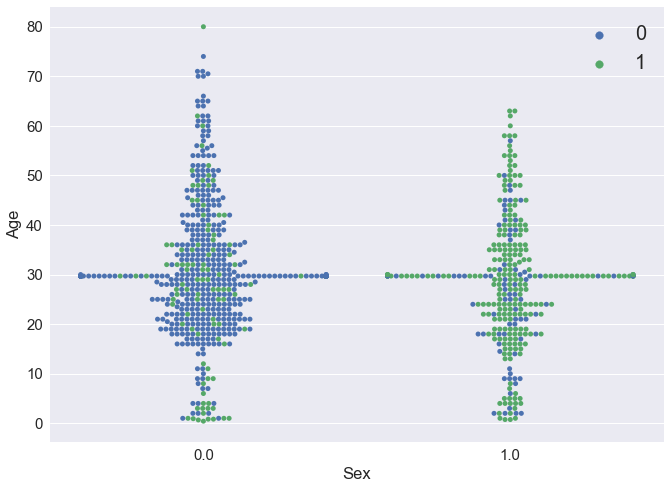

In [262]:
# Male/Female vs age
# wideform dataframe
age_vs_sex = pd.DataFrame.from_dict({'Sex':Xdf['Sex'], 'Age':Xdf['Age'], 'Survived':df['Survived']})
print(age_vs_sex.head())

# Draw a categorical scatterplot to show each observation
fig, ax = plt.subplots()
fig.set_size_inches(11,8)
sns.set()
sns.swarmplot(x="Sex", y="Age", hue="Survived", data=age_vs_sex)
sns.set(font_scale=1.5)
plt.legend(prop={'size':20})

print("Score for 'Female survived': {:.1f}%".format((np.sum(df['Survived']==Xdf['Sex'])/num_samples)*100))

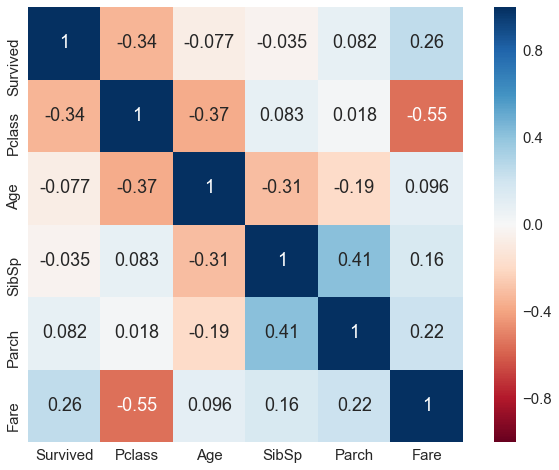

In [281]:
# Plot correlation matrix
plt.figure(figsize=(11,8))
sns.heatmap(df.corr(),square=True,annot=True,cmap="RdBu")

## Feature Engineering

In [207]:
# Removing "Name" column and converting into individual features based on rare names
rareTitles = ["Master", "Dr.", "Rev."]
for i in np.arange(len(rareTitles)):
    Xdf[rareTitles[i]] = Xdf["Name"].str.contains(rareTitles[i]).astype(int)
Xdf = Xdf.drop(["Name"], axis=1)

In [278]:
Xdf["chwPar"] = ((Xdf["Age"]<=8) & (Xdf["Parch"]>=1)).astype(int)
Xdf["parwCh"] = ((Xdf["Age"]>=20) & (Xdf["Parch"]>=1)).astype(int)

In [234]:
# Converting 
Xdf["chwPar"] = Xdf[(Xdf["Age"]<=8) & (Xdf["Parch"]>=1)]

ValueError: Wrong number of items passed 10, placement implies 1

## Training Classifier

In [45]:
startTime = datetime.now()

# turn that dataframe into a numpy array
X = Xdf.as_matrix()

# split into training and test set
[Xtrain, Xtest, Ytrain, Ytest] = ms.train_test_split(X, Y, train_size=trainTestSplit)

# train a random forest classifier on our training set
rand_forest = RandomForestClassifier(n_estimators=30)
# n_estimators=10, max_depth=None, min_samples_split=2, random_state=0

# use GridSearchCV to tune the following hyperparameters:
# min_samples_split == minimum samples in node to perform a split
# max_features == max number of features used to perform a split
parameters = {'min_samples_split':[2,3,4,5,6], 'max_features':[1,2,3,4,5,6,7]}
b = len(parameters['min_samples_split'])
a = len(parameters['max_features'])

clf = ms.GridSearchCV(rand_forest, parameters, cv=nfold)
clf.fit(Xtrain, Ytrain)

sorted(clf.cv_results_.keys())
# print(clf.best_params_)
# print('means')
# print(clf.cv_results_['mean_test_score'])
# print('stds')
# print(clf.cv_results_['std_test_score'])
# print("Time to run: {}".format(datetime.now() - startTime))



['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'mean_train_score',
 'param_max_features',
 'param_min_samples_split',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split0_train_score',
 'split1_test_score',
 'split1_train_score',
 'split2_test_score',
 'split2_train_score',
 'split3_test_score',
 'split3_train_score',
 'split4_test_score',
 'split4_train_score',
 'split5_test_score',
 'split5_train_score',
 'split6_test_score',
 'split6_train_score',
 'split7_test_score',
 'split7_train_score',
 'split8_test_score',
 'split8_train_score',
 'split9_test_score',
 'split9_train_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score',
 'std_train_score']

In [7]:
clf.best_params_

{'max_features': 5, 'min_samples_split': 5}

In [8]:
clf.cv_results_["mean_test_score"]

array([ 0.79494382,  0.80337079,  0.80758427,  0.80898876,  0.81460674,
        0.79073034,  0.79775281,  0.81179775,  0.80196629,  0.80617978,
        0.82022472,  0.80477528,  0.81882022,  0.8005618 ,  0.81601124,
        0.8005618 ,  0.81320225,  0.80337079,  0.81741573,  0.81741573,
        0.80758427,  0.80758427,  0.81179775,  0.82162921,  0.81039326,
        0.81179775,  0.81320225,  0.80898876,  0.80758427,  0.81882022,
        0.81460674,  0.81179775,  0.80898876,  0.81320225,  0.80617978])

In [9]:
clf.cv_results_["mean_test_score"].reshape([a,b])

array([[ 0.79494382,  0.80337079,  0.80758427,  0.80898876,  0.81460674],
       [ 0.79073034,  0.79775281,  0.81179775,  0.80196629,  0.80617978],
       [ 0.82022472,  0.80477528,  0.81882022,  0.8005618 ,  0.81601124],
       [ 0.8005618 ,  0.81320225,  0.80337079,  0.81741573,  0.81741573],
       [ 0.80758427,  0.80758427,  0.81179775,  0.82162921,  0.81039326],
       [ 0.81179775,  0.81320225,  0.80898876,  0.80758427,  0.81882022],
       [ 0.81460674,  0.81179775,  0.80898876,  0.81320225,  0.80617978]])

{'max_features': 5, 'min_samples_split': 5}
[ 0.79494382  0.80337079  0.80758427  0.80898876  0.81460674  0.79073034
  0.79775281  0.81179775  0.80196629  0.80617978  0.82022472  0.80477528
  0.81882022  0.8005618   0.81601124  0.8005618   0.81320225  0.80337079
  0.81741573  0.81741573  0.80758427  0.80758427  0.81179775  0.82162921
  0.81039326  0.81179775  0.81320225  0.80898876  0.80758427  0.81882022
  0.81460674  0.81179775  0.80898876  0.81320225  0.80617978]


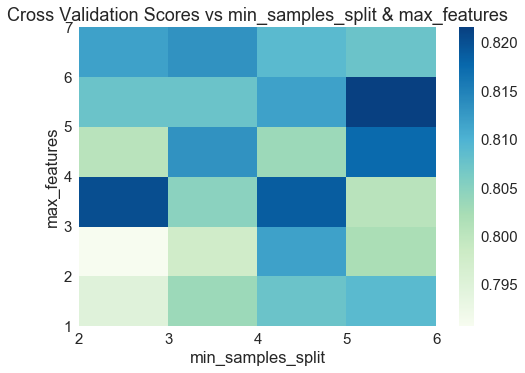

In [10]:
print(clf.best_params_)
print(clf.cv_results_['mean_test_score'])

cvScores = clf.cv_results_["mean_test_score"].reshape([a,b])
plt.pcolor(parameters['min_samples_split'],parameters['max_features'],cvScores,cmap=colorMap)
#plt.axis([gamvec.min(), gamvec.max(), Cvec.min(), Cvec.max()])
plt.colorbar()
plt.xlabel('min_samples_split')
plt.ylabel('max_features')
plt.xticks(parameters['min_samples_split'])
plt.yticks(parameters['max_features'])
plt.title('Cross Validation Scores vs min_samples_split & max_features')
#plt.plot(gamopt,Copt,marker='*',color='r',markersize=14)